<a href="https://colab.research.google.com/github/Sahil-Rajarai/text-processing/blob/master/2019_Text_as_Data_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text processing and clustering

The aims of the lab are to:
*   Learn to perform text processing: tokenization, normalization, and segmentation of text 
*   Calculate basic collection statistics of a corpus of text
*   Introduce the spaCy python library for text processing 
*   Learn the details of how a *dictionary* is implemented
*   Practice creating a sparse one-hot encoding 
*   Implement Jaccard similarity
*   Learn to use SciKit-Learn to vectorize text with a bag-of-words representation
*   Use Cosine similarity to find similar documents in a collection


## Submission

* You must submit the ipynb of this file following the instructions on the [submission page](https://moodle.gla.ac.uk/mod/assign/view.php?id=1409110).

* Instead of auto-grading, the marks for this lab are computed using [a Moodle quiz](https://moodle.gla.ac.uk/mod/quiz/view.php?id=1409115).  You will be allowed up to two submissions (in case there is a mistake the first time). 


## Setup 

#### Your task:####
Just run the cells below, and verify that the output is as expected. If anything looks wrong, weird, or crashes, contact the course staff. We don't want library issues to get in the way of the real work! 

In [0]:
import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("numpy", "1.14")
version_check("matplotlib", "1.6")
version_check("pandas", "0.22")

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
numpy version 1.17.4 is
OK
matplotlib version 3.1.2 is
OK
pandas version 0.25.3 is
OK


# Load and process Reddit data
This lab will be performed on a 'real-world' collection of Reddit posts.  

The main unit of processing is a reddit *thread*; it represents a discussion topic with a unique URL. The thread contains metadata as well as the *posts* within it. A *post* is a single user entry in a thread. A post has the *body*, its *author*, it's position in the thread, as well as other metadata. 

**Thread fields**
*   URL - reddit URL of the thread
*   title - title of the thread, as written by the first poster
*   is_self_post - True if the first post in the thread is a self-post (text addressed to the reddit community as opposed to an external link)
*   subreddit - the subreddit of the thread
*   posts - a list of all posts in the thread

**Post fields**
*   id - post ID, reddit ID of the current post
*   body - the text of the post
*   in_reply_to - parent ID, reddit ID of the parent post, or the post that the current post is in reply to
*   post_depth - the number of replies the current post is from the initial post
*   is_first_post - True if the current post is the initial post


Download the Reddit dataset. It's approximately 80 megabytes. It's recommended that this is done in a Colab notebook for this reason. 

In [0]:
# The local location to store the reddit dataset.
local_file = "coarse_discourse_dump_reddit.json"

# The ! performs a shell command to download the reddit dataset from a Google cloud bucket. If you use this
# in jupyter directly, there is an equivalent command with wget below.
!gsutil cp gs://textasdata/coarse_discourse_dump_reddit.json $local_file
  
# The ! performs a shell command to download the reddit dataset using wget.
#!wget -O  $local_file https://storage.googleapis.com/textasdata/coarse_discourse_dump_reddit.json


Copying gs://textasdata/coarse_discourse_dump_reddit.json...
- [1 files][ 78.5 MiB/ 78.5 MiB]                                                
Operation completed over 1 objects/78.5 MiB.                                     


Note: We will be using the Pandas library as a way to manipulate the data easily.  Please refer to the [documentation](https://pandas.pydata.org/pandas-docs/stable/), or to this [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) if you get stuck. 

Load the JSON data into DataFrame with each post as a row.

In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and cates a new data frame.
import pandas as pd
import json

# A temporary variable to store the list of posts.
posts_tmp = list()

with open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    thread = json.loads(line)
    for post in thread['posts']:
      # Keep the thread title and subreddit with each post.
      posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', "")))
# Create the posts data frame.  
labels = ['subreddit', 'title', 'url', 'id', 'author', 'body']
post_frame = pd.DataFrame(posts_tmp, columns=labels)
# print(post_frame['title'])

Let's learn more about the Reddit collection statistics. 

#### Your Task
Use `count()` on the `posts_frame` object to print a count distribution. 
- Note: `count()` gives count values for each column in the frame independently.

In [0]:
post_frame.count(axis=0)

subreddit    110595
title        110595
url          110595
id           110595
author       110595
body         110595
dtype: int64

This should yield 110,595 for all the fields. 

#### Your task:
Select the subreddit column from the `post_frame` and store it in a variable, `subreddits`.

The result is a Series object.  

Use the [value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) feature to group and count the values for the `subreddits` series.

Using the value_counts on the `subreddits` variable do the following:
 - Print a statistical summary of the data using `.describe() `
 - Use `head()` to print out the top 5 subreddits with their counts

In [0]:
subreddits = post_frame['subreddit']
counts = subreddits.value_counts()
desc = counts.describe() 
heads = counts.head()

# print(subreddits)
print(desc)
# print(heads)

count    2842.000000
mean       38.914497
std       130.537942
min         1.000000
25%         7.000000
50%        14.000000
75%        34.000000
max      5150.000000
Name: subreddit, dtype: float64


- What information is provided by the describe() function? 
- Information about the mean, std, minimum and maximum counts are shown.
- What does this statistical summary tell you about the frequency distrubution of threads in subreddits?  

#### Your task
Let's examine the question of how posts relate to threads. Each post has the thread it came from, defined by its URL.  Select the URLs and count the values.  Similar to the previous task, print out the statistical summary using describe.  

In [0]:
url = post_frame['url']
counts = url.value_counts()
desc = counts.describe() 
heads = counts.head()

print(desc)

count    9401.000000
mean       11.764174
std         9.215183
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max        41.000000
Name: url, dtype: float64


- Critically look at these statistics.  
- What is the shortest thread, longest thread?
- What about the average?

### Your task:

- Print a simple bar graph to visualize the top 20 most popular sub-reddits by number of posts. 

**Hint**: Again, the Series object from value_counts has built-in functionality for getting the most frequent as well as plotting, look for "largest".  

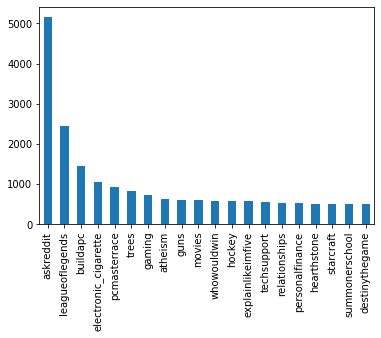

In [0]:
# Note: need this for Jupyter on local machines to work
# import matplotlib.pyplot as plt; plt.rcdefaults()
# import numpy as np
# import matplotlib.pyplot as plt
subreddits  = post_frame['subreddit']
subreddits.value_counts()[:20].plot(kind='bar')

# subreddits = post_frame['id']
# counts = subreddits.value_counts()
# print(counts)
# keys = subreddits.value_counts().keys().tolist()
# values = subreddits.value_counts().tolist()
# popular_post = {}

# for i in range(20) :
#   post = post_frame[post_frame['id']==keys[i]]['subreddit'].tolist()
#   # print(post[0])
#   popular_post[post[0]] = values[i]

# print(popular_post)
# plt.bar(range(len(popular_post)), list(popular_post.values()))
# plt.xticks(range(len(popular_post)), list(popular_post.keys()), rotation=90)

# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

# plt.show()


#### Your task 
- Create a bar plot of the top 10 authors of reddit posts.

*Note:* Not all posts have authors. As a first step you need to `replace` all empty values in the frame with a numpy nan value `np.nan`, after doing this pandas will filter them out automatically.

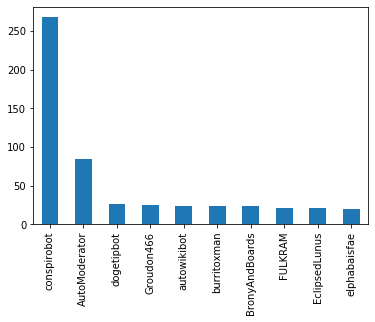

In [0]:
import numpy as np
# import math
post_frame_copy = np.copy(post_frame)
post_frame_copy = post_frame.replace(r'^\s*$', np.nan, regex=True)
authors  = post_frame_copy['author']
authors.value_counts()[:10].plot(kind='bar')

## Introduction to spaCy
[spaCy](https://spacy.io/) is an open-source software library for Natural Language Processing, written in Python and Cython. 

**Note:** SpaCy includes a variety of models. Below we use the english web small. In practice, better effectiveness can be obtained by using a larger model. See the full list of [models](https://spacy.io/usage/models).   

In [0]:
!python -m spacy download en

import spacy
import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("spacy", "2.0")

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
print(nlp.pipeline)
print(nlp.pipe_names)
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
# Verify they are empty.
print(nlp.pipeline)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
spacy version 2.1.9 is
OK
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fdd7b164748>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fdd7b84c228>)]
['tagger', 'parser']
[]


### Step 1: Tokenization

Below is example code of processing the body of a Reddit post with spaCy. The code below prints out a few of the properties of the [Token](https://spacy.io/api/token) class. This class exposes many useful properties of tokens.



In [0]:
doc = nlp(post_frame.loc[10]['body'])
for token in doc[:30]:
    print("{0}\t{1}\t{2}\t{3}\t{4}".format(
        token.text,
        token.idx,
        token.lemma_,
        token.is_punct,
        token.is_space,
    ))

I	0	I	False	False
love	2	love	False	False
cheese	7	cheese	False	False
cake	14	cake	False	False
!	18	!	True	False
I	20	I	False	False
love	22	love	False	False
both	27	both	False	False
making	32	make	False	False
and	39	and	False	False
eating	43	eat	False	False
it	50	it	False	False
,	52	,	True	False
so	54	so	False	False
I	57	-PRON-	False	False
'm	58	be	False	False
sad	61	sad	False	False
to	65	to	False	False
see	68	see	False	False
that	72	that	False	False
they	77	they	False	False
usually	82	usually	False	False
have	90	have	False	False
the	95	the	False	False
most	99	much	False	False
crazy	104	crazy	False	False
calorie	110	calorie	False	False
counts	118	count	False	False
,	124	,	True	False
and	126	and	False	False


Note that spaCy includes the raw token, it's position in the original string, the lemma (using its [lemmatizer](https://spacy.io/api/lemmatizer)), as well other properties of the token. 

- How does spaCy handle punctuation?
- How about splitting based on apostrophes?

## Tokenization and normalization with spaCy

#### Task
- Define a function ``spacy_tokenize`` function that uses spaCy to tokenize a string. The function should:
 - Accept a string as input
 - Output a list of spaCy token objects

In [0]:
def spacy_tokenize(str) :
  lst_tokens = []
  str = nlp(str)
  for token in str :
    # print(token)
    lst_tokens.append(token)
  
  return lst_tokens
  
spacy_tokenize('I love cheese cake! I love both making and eating it, so.')


[I, love, cheese, cake, !, I, love, both, making, and, eating, it, ,, so, .]

Below we  apply the ``spacy_tokenize`` function to the ``body`` field of the posts in the ``post_frame`` DataFrame. The results are flattened into a ``flat_tokens`` variable that contains a single list of all tokens from all posts concatenated together. 

Note: Applying spaCy's tokenizer to all the posts will take a couple minutes. 

In [0]:
# This tokenizes the body posts and creates vector of tokens for each post.
# Note: This selects the body column from the posts only. 
all_posts_tokenized = post_frame.body.apply(spacy_tokenize)

import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

#### Task

- Inspect some of the posts' tokenization to verify that it worked correctly 
- Print out the 50 most frequent (common) terms in the Reddit collection with their term frequencies (TF). 
- *Hint*: You'll need to use a property of the token object, not the full token object.

Use the python [collections.Counter](https://docs.python.org/2/library/collections.html) library. See it's documentation for examples on how to use it.

A `Counter` is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.



In [0]:
from collections import Counter

lst_counts = []

for i in range(len(flat_tokens)) :
  lst_counts.append(flat_tokens[i].text)

counts1 = Counter(lst_counts)
print(counts1.most_common(50))


[('.', 244366), (',', 175780), ('the', 162023), ('I', 137844), ('to', 122575), ('a', 110137), ('and', 97916), ('of', 72791), ('it', 70102), ('you', 68689), ('is', 60717), ('\n\n', 60224), ('that', 57067), ('in', 53429), ('for', 45987), ("'s", 39097), ('-', 38371), ("n't", 38080), ('*', 36234), (')', 36013), ('have', 33916), ('on', 33566), ('/', 33269), ('with', 32348), ('be', 32021), ('?', 30778), (' ', 29761), ('but', 29660), ('"', 28576), ('do', 28235), ('are', 25939), ('my', 25551), ('was', 24350), ('this', 24038), ('not', 23652), ('(', 23354), ('as', 23012), ('or', 21546), ('!', 20633), ('your', 19854), ('like', 19402), ('can', 19185), ('if', 19178), ('just', 19111), ('they', 18447), ('at', 17642), ('so', 17564), ('would', 17561), ('\n', 16508), ('me', 15459)]


You may observe that some of the tokens are 'noisy'. Some may be line breaks as well as various other types of punctuation.

### Step 2: Text Normalization

In this section we will apply simple text normalization. We will write a function that takes raw tokens and normalizes them.

#### Task:
Create a ``normalize`` function that normalizes raw text into a canonical form. The function should:
 - Take a list of spaCy token objects as input
 - Output a list of normalized strings

Simple Normalization algorithm:
 - Normalization should only keep tokens consisting of alphanumeric characters.    (Hint: See Spacy's [token object](https://spacy.io/api/token) documentation for character classes.) 
 - Normalization should use Spacy's lemma property for the word representation. 
 - Output should be lowerecased 
 - Extra whitespace on the ends should be removed. 
 - One edge case to handle is when Spacy's lemma is "-PRON-". In this case, preserve the lowercased text token instead.
 

The follow-up answers depend on this code being correct. Once you've written your version, please check it with the code below.  Click SHOW CODE to see it.

In [0]:
import re

def normalize(tokens):
  normalized = list()
  # tokens = nlp(tokens)

  for token in tokens:
     if token.is_alpha:
       if token.lemma_ != "-PRON-" :
         lemma = token.lemma_.lower().strip() 
       else :
         lemma = token.lower_
      # lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
       normalized.append(lemma)
  
  return normalized

  
# print(normalize(['szzx', '.', 'sasa']))

In [0]:
#@title
def normalize(tokens):
  normalized = list()
  for token in tokens:
    if (token.is_alpha):
      lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
      normalized.append(lemma)
  return normalized

The code below runs the ``normalize`` function on the ``flat_tokens`` and stores it in ``normalized_tokens``. We will use these for our vocabulary and processing.

In [0]:
normalized_tokens = normalize(flat_tokens)

for i in range(20) :
  print(normalized_tokens[i])


it
be
only
a
few
minute
into
robert
altman
homespun
epic
nashville
that
i
get
the
feel
i
be
watch


#### Your task
Fill in the blanks in the code below to compute the statistics for the collection. 


*Hint:* Python has built-in `set()` data structure to create unique the values.

In [0]:
# # |N| - total number of raw unnormalized tokens (Hint: recall flat_tokens)
N_raw = len(flat_tokens)

# # # Average post length in raw, unnormalized, tokens
sum = 0
for t in all_posts_tokenized :
  sum += len(t)
# token_lengths = [len(t) for t in all_posts_tokenized]
average_raw_token_length = sum / len(all_posts_tokenized)

# # Size of raw (unnormalized) unique tokens
final_list = set() 
for token in flat_tokens: 
  final_list.add(token.text) 
B = len(final_list)


# Set of unique normalized tokens (from normalized_tokens) --> the vocabulary
V = set(normalized_tokens)
# for token in normalized_tokens: 
#   V.add(token) 
L = len(V)
print(L)


print(N_raw)
print(average_raw_token_length)
print(B)
print(V)

72368
5588744
50.53342375333424
154316
{'ghostbc', 'cd', 'repetitive', 'catelyns', 'chocolat', 'golden', 'swo', 'imola', 'auditorium', 'lubricant', 'contract', 'downsize', 'objects', 'damn', 'totemed', 'cryptocurrencies', 'chestpack', 'datatables', 'row', 'albeit', 'serge', 'monochrome', 'deñe', 'circumcise', 'friendlist', 'towers', 'halakhicly', 'pseudocl', 'tcu', 'grades', 'redwynes', 'showphysics', 'ancestry', 'kreider', 'flying', 'pyserial', 'headquarter', 'certificates', 'warbear', 'spitting', 'progresspics', 'sizzler', 'seed', 'paxson', 'bartók', 'chortle', 'majinn', 'binder', 'xseries', 'speeda', 'hymie', 'cocksucker', 'mosaic', 'jakarr', 'lifeforms', 'gloucester', 'device', 'millerville', 'turbulence', 'arnie', 'judicious', 'evans', 'snme', 'unfathomably', 'nexrt', 'batgirl', 'masquerade', 'lbj', 'rung', 'arenanet', 'rishon', 'bullshitter', 'watergardens', 'reyestopete', 'skeletal', 'kustom', 'triceratops', 'zulu', 'penner', 'anor', 'menthol', 'roberts', 'microscope', 'für', 'w

- Hint: N should between 5-6 million tokens. 
- B is approximately 150k unique raw tokens 

Normalization matters -- the vocabulary is roughly half the number of unique unnormalized tokens.

#### Optional task
- On all_posts_tokenized compute the length of each token in characters.  Consider using `describe()` to compute the full suite of statistics. 



## One-hot encoding

We will now implement a one-hot encoding text representation using a dictionary.

Below is a skeleton class that implements a dictionary.  Recall from lecture that a dictionary allows us to translate a series of tokens to integer values (and back).

#### Your task
- The ``SimpleDictionary`` skeleton below is incomplete, fill in the missing elements. Specifically:  
 - Complete the ``_init_`` constructor to initialize all the member variables appropriately from the token input
 - Implement the ``tokens_to_ids`` function that maps strings to integer values

In [0]:

class SimpleDictionary(object):
  
  # Special UNK token for unseen tokens
  UNK_TOKEN = "<unk>"

  def __init__(self, tokens, size=None):
    UNK_TOKEN = "<unk>"
    # Map of unigram tokens to their count.
    # Hint: Recall the Counter object.
    self.unigram_counts = Counter(tokens)
    
    # The size of the vocabulary, |V|.
    # Hint: Consider using the data structure containing the unigram_counts.
    self.vocabulary_size = len(self.unigram_counts)

    # The total number of tokens in the collection, |N|
    self.collection_size = len(tokens)

    # Vocabulary - most frequent unique terms 
    # (Note: This is limited by the *size* parameter passed in.)
    # These should be in descending order of collection frequency.
    # Remember to add the "<unk>" token. 
    # It should go first in the ordering. Why might this be the case?
    self.vocab = []
    self.vocab.append(UNK_TOKEN)
    self.vocab.extend(i[0] for i in self.unigram_counts.most_common(self.vocabulary_size))

    # Dictionary that assigns an id to each token, based on frequency.
    # Hint: use a dictionary data structure with the vocab.
    self.id_to_token = {}
    for i in range(len(self.vocab)) :
        self.id_to_token[i] =  self.vocab[i]
    
    # Dictionary that assigns a token to its id
    # Hint: The reverse of the id_to_token dictionary.
    self.token_to_id = {} 
    self.token_to_id = {v: k for k, v in self.id_to_token .items()}

    
    self.size = len(self.id_to_token)
    if size is not None:
        assert(self.size <= size)

    # For convenience keep a set of unique words.
    self.tokenset = set(iter(self.token_to_id.keys()))

    # Store special IDs for convenience
    self.UNK_ID = self.token_to_id[self.UNK_TOKEN]

  # Given a sequence of ids, return a sequence of corresponding tokens.
  def ids_to_tokens(self, ids):
    return [self.id_to_token[i] for i in ids]
  
  # Given an input sequence of tokens, return a sequence of token id.
  # This performs the vectorizing of text.
  def tokens_to_ids(self, tokens):
    tokenId = []
    for token in tokens :
      if token not in self.vocab :
        tokenId.append(0)
      else :
        tokenId.append(self.token_to_id.get(token))
    
    return tokenId

Run the dictionary on the ``normalized_tokens`` that contains all of the tokens in the collection.  In Sci-kit Learn this is called "fitting", creating a vocabulary from a fixed collection of text. 

In [0]:
dictionary = SimpleDictionary(normalized_tokens)

#### Verification task

- Use the ``dictionary`` to print out properties of the text collection. 

 - Print out the total number of tokens (N)
 - Print out the size of the vocabulary  (V)
 - Print out the top 20 most frequent unigrams with three values: token, collection frequency, percentage of collection tokens.

The vocabulary size should match |V| from above. 
In this case the normalized |N| will be smaller than raw token counts -- approximately 4.5M normalized tokens.

In [0]:
#@title
print("Collection size: " + "{0}".format(dictionary.collection_size))
print("Vocabulary size: " + "{0}".format(dictionary.vocabulary_size))

for (word, count) in dictionary.unigram_counts.most_common(20):
  print("{0}\t{1}\t{2}".format(word, count, 100 * count / dictionary.collection_size))

Collection size: 4449028
Vocabulary size: 72368
the	175936	3.954481742978466
be	167894	3.773723159305808
a	149416	3.358396485704293
i	146584	3.2947421324388158
to	124878	2.8068602849880917
and	102055	2.29387182998174
it	83701	1.8813322820175553
you	78023	1.7537089000114183
of	73378	1.6493040727098143
that	66063	1.4848861369269872
in	56212	1.2634669864968258
have	56017	1.2590840066639275
for	48242	1.0843267338393914
do	48227	1.083989581544553
on	34400	0.7732025961625776
but	34350	0.7720787551797831
with	33157	0.7452639093303076
this	32614	0.73305899625716
can	31966	0.718494017120144
my	29458	0.6621221534231747


The most frequent word, *the*, accounts for approximately 4% of all tokens.  The top 10 most frequent words account for over 25% of all word occurrences.  Recall [Zipf's law](https://simple.wikipedia.org/wiki/Zipf%27s_law) and the power law distribution of text data. A few number of terms account for a large fraction of occurrences, but many words occur rarely. 

### From tokens to IDs and back again
Below are some examples of using the dictionary to map tokens to IDs in our vocabulary (and vice versa). Consider trying some of your own words to experiment with what happens here. 

In [0]:
# Pick a word from the dictionary
print(dictionary.tokens_to_ids(["a"]))

# What's the value of a made up word? 
print(dictionary.tokens_to_ids(["uphalyday"]))

# For fun, let's print out a couple random words from the vocab.
# Feel free to explore the vocabulary.
import random as rand
print(dictionary.ids_to_tokens([5]))
print(dictionary.ids_to_tokens([rand.randint(0, dictionary.size-1)]))

[3]
[0]
['to']
['cmdlets']


### Creating a one-hot encoding representation

#### Your task
- Create a function: ``one_hot_encoding`` that uses the ``SimpleDictionary`` to take a string and return a vector of integers:
 - Takes a string as input and applies tokenization and normalization using the provided ``tokenize_normalize`` function.
 - Output a sparse one-hot encoding of the text (sorted in ascending term id order). 
 - Test the code by running it on the post in row index 10 in the post_frame.



In [0]:
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [0]:
def one_hot_encoding(str) :
  normalized_str = tokenize_normalize(str)
  token_id = dictionary.tokens_to_ids(normalized_str)
  results = sorted(set(token_id))
  # print(token_id[:,10]
  return results
  

In [0]:

post = post_frame.loc[10]['body']
# print(post)
print(len(spacy_tokenize(post)))
print(one_hot_encoding(post))
print(len(one_hot_encoding(post)))


111
[1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 19, 21, 23, 26, 27, 35, 39, 46, 54, 57, 63, 65, 67, 89, 93, 98, 105, 132, 152, 166, 179, 223, 239, 240, 271, 272, 321, 341, 352, 412, 458, 533, 537, 720, 739, 1109, 1339, 1484, 1552, 1575, 1798, 1883, 1996, 2269, 2838, 3231, 4087, 4810, 18070, 38717, 38718]
62


The original input sequence for the post has 111 raw tokens. The one-hot encoding should be a list of with 62 values (including all of tokens 1-7). 

A sparse one-hot encoding is common and is easily to compress.

Try creating a one-hot encoding of your favorite sentence.

## Jaccard similarity betwen pieces of text

#### Your task 

- Implement a function ``jaccard_similarity`` that takes two documents represented as sparse one-hot encodings and computes the jaccard similarity. 
- *Hint*: You might want to look at the operations on the built-in set datastructure 
(https://docs.python.org/3/tutorial/datastructures.html#sets)
- *Debugging Tip*: Consider printing the different elements of Jaccard. 

In [0]:
def jaccard_similarity(list1, list2) :
  intersection = len(list(set(list1).intersection(list2)))
  union = (len(list1) + len(list2)) - intersection
  return float(intersection) / union

In [0]:
doc1 = one_hot_encoding("the cat jumped over the fox")
doc2 = one_hot_encoding("the brown fox jumped over the dog")

print(doc1)
print(doc2)
jaccard_similarity(doc1, doc2)

[1, 117, 754, 1292, 2837]
[1, 117, 486, 754, 1643, 2837]


0.5714285714285714

Implementing other one-hot encoding similarity measures should be easy for you to do now. 

### Section summary
In the previous section we: 
 - Created a dictionary object and used it to represent text. 
 - Created a one-hot encoding of text documents
 - Implemented the Jaccard similarity function 


We could also have extended our functions to create bag-of-words representations.  In the next section we'll explore how to do this with one of the most widely used machine learning libraries. 

## Vector representations with Scikit-Learn

Scikit-learn is a widely machine learning library that includes tools for performing operations on data: similarity computation, clustering, classification, and many others. You'll now use Scikit-learn to create vector representations of text.

We first extract out a few fields from the DataFrame and put it into a friendlier format. 

In [0]:
from itertools import islice

# Parallel arrays of the post keys and values.
post_vals = list()
post_keys = list()

# We limit the size of the data loaded to the first 5000 posts to speed processing.
posts_to_load = 5000

for post in islice(post_frame.itertuples(index=True, name='Pandas'), posts_to_load):
    post_keys.append(getattr(post, 'id'))
    post_vals.append(getattr(post,'body'))

#### Your task
Create a document-term matrix with term frequency (counts) from the Reddit posts using the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). This creates a bag-of-words representation for a document. 

The code will have the following steps:
 - Import the ``CountVectorizer`` and create an instance; assign it to a variable, ``tf_vectorizer``
 - All Scikit-Learn vectorizers accept a tokenizer as an optional parameter (it has a built-in tokenizer).  Pass in the ``tokenize_normalize`` function created earlier by using ``CountVectorize (tokenizer=...)``. This tokenizes and normalizes with spaCy. 
 - Call ``fit`` on the ``post_vals`` variable to 'learn' the vocabulary on the collection, similar to the constructor in SimpleDictionary.
 - Call ``transform`` on the ``post_vals`` to create a document-term matrix, assign it to a variable, `tf_document_term_matrix`.

Note: Running this processing on the whole collection make take approximately 5 minutes in a colab instance. The small dataset should take a few seconds.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(tokenizer=tokenize_normalize)
X1 = tf_vectorizer.fit(post_vals)
Y1 = tf_vectorizer.transform(post_vals)



What did this process do?
 - The ``fit()`` function tokenized the text collection and built a vocabulary/dictionary 
 - The ``transform()`` function created a document-term matrix with a bag-of-words representation (raw TF) word counts as the weighting.
 
 These steps are sometimes combined together with the single step called ``fit_transform``.  The constructor of ``CountVectorizer`` accepts parameters on how to control the dictionary created. 

Let's now apply the vectorizer on new unseen text.  We do this by calling ``transform()`` on the string data (technically an array of strings, each entry a document). 


In [0]:
mystring = 'The next town over recently got a brand new flagship Lidl – now my town is getting a brand new flagship Aldi. I fear war.'
response = tf_vectorizer.transform([mystring])
print (response)
print (tf_vectorizer.inverse_transform(response))

  (0, 4)	2
  (0, 808)	1
  (0, 1079)	2
  (0, 3115)	1
  (0, 3545)	2
  (0, 4133)	1
  (0, 5537)	1
  (0, 5656)	2
  (0, 5667)	1
  (0, 5762)	1
  (0, 6015)	1
  (0, 6891)	1
  (0, 8447)	1
  (0, 8629)	2
  (0, 9174)	1
[array(['a', 'be', 'brand', 'fear', 'get', 'i', 'my', 'new', 'next', 'now',
       'over', 'recently', 'the', 'town', 'war'], dtype='<U41')]


This outputs the term-doc matrix with term frequency values. The output has several parts:  
 - (0, 17) 2 --> (doc row, column) term_frequency
 
 
 What happened? 
 - ``Transform`` applies the vectorizor, just like ``tokens_to_ids`` in the dictionary implementation.  
 - The result is a document-term matrix for the data passed to it. 
 
 The ``inverse_transform`` is just like ``ids_to_tokens`` applied to every non-UNK value (which are not invertable).  

**Note:** We do not call ``fit`` on `mystring`.  Why? What would this have done?

In the inverse output,  see that some of the words are not present (e.g. lidl, aldi, etc...). 

These are just ignored; calling ``transform()`` does not update our vocabulary and there is no UNK representation in its vocabulary. This is important -- Scikit-Learn blindly ignores all UNK tokens that haven't been seen when using a vectorizer; be careful. 

#### Your task 
- Create a TF-IDF vectorizer, name it `tfidf_vectorizer` and use it to vectorize ``post_vals`` similar to what was done for CountVectorizer. 
 - Use the [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
 - Set `sublinear_tf` = True to use the log scaling (as opposed to raw TF counts)
 - Limit the number of features (the size of the vocabulary) to 50000
 - Assign the resulting document-term matrix to a variable: `tfidf_matrix` 
 
Read the documentation of the vectorizer for details on the parameters as needed.  Warning: if this takes too long (e.g. more than 5 minutes or so), or crashes then your configuration is wrong.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

IdfVectorizer = TfidfVectorizer(sublinear_tf = True, max_features = 50000, tokenizer=tokenize_normalize)
X2 = IdfVectorizer.fit(post_vals)
tfidf_matrix = IdfVectorizer.transform(post_vals)


## Cosine similarity
We will now use sklearn's `cosine_similarity` implementation to compute the cosine similarity between all posts, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

**Task:** Import the `cosine_similarity` function.
- Create a cosine similarity matrix of all pairs of documents.
- Use the `tfidf_matrix` as the input.
- Print the resulting cosine similarity matrix.
- Find the maximum cosine similarity for the first document (first row), excluding itself (first column).

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

matrix = cosine_similarity(tfidf_matrix)
print(matrix)
print(matrix[0,1:].max())

[[1.         0.18854769 0.17859811 ... 0.06614524 0.0881675  0.11093973]
 [0.18854769 1.         0.09227255 ... 0.05656999 0.05016301 0.09550758]
 [0.17859811 0.09227255 1.         ... 0.07200569 0.06925672 0.08931065]
 ...
 [0.06614524 0.05656999 0.07200569 ... 1.         0.3370475  0.19542768]
 [0.0881675  0.05016301 0.06925672 ... 0.3370475  1.         0.26382708]
 [0.11093973 0.09550758 0.08931065 ... 0.19542768 0.26382708 1.        ]]
0.24206481568775035


You should see that there are 1s across the diagonal of the matrix as the similarity of a post to itself is 1. 

For your own enrichment you can use this as a basis to experiment with different vectorizers and matrix representations (count, tfidf, ngrams). For example, also removing stopwords or other non-informative words
- How do the post similarities change?
- How could you measure if this effective?

## Summary 

In this lab we covered the fundamentals of texting processing:
- We introduced spaCy for text processing
- You implemented a dictionary and created a one-hot encoding of text
- Implemented the Jaccard similarity function
- Used Sci-kit Learn to vectorize text using bag-of-words representation with TF and TF-IDF weights 
- Computed the cosine similarity between Reddit posts